https://www.promptingguide.ai/techniques/prompt_chaining

In [ ]:
import openai

In [3]:
def read_txt(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
    return content.strip()

In [4]:
openai.api_key = read_txt("C:/Users/피엔케이피부임상연구센타(주)/Desktop/♣Prompt_Engineering/open_ai_personal_key.txt")

# Zero-shot

In [5]:
def zero_shot(prompt):
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message['content']

# Few-shot

In [6]:
def few_shot(prompt):
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[
            {"role":"system","content":role},
            
            #Few Shot starts here:
            {"role":"user","content":shot_one_input},
            {"role":"assistant","content":shot_one_output},
            {"role":"user","content":shot_two_input},
            {"role":"assistant","content":shot_two_output},
            {"role":"user","content":shot_three_input},
            {"role":"assistant","content":shot_three_output},
            
            #Finally send the data for which we want GPT to run the prompt and find solution
            {"role":"user","content":prompt}
            ]
    )
    return response.choices[0].message['content']

# CoT (Chain of Thought)

### Zero-shot CoT

In [18]:
def zero_shot_cot(prompt):
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are a logical problem solver who always think a problem through step by step, one by one"},

            # Send the data for which we want GPT to find a solution
            {"role": "user", "content": prompt},
            {"role": "assistant", "content": "Let's think step by step."}
#             {"role": "assistant", "content": "Let's think not just step by step, but also one by one."}
            ]
    )
    return response.choices[0].message['content']

### Few-shot CoT (Manual-CoT) 
- demonstration manually designed
- better performance than zero-shot CoT

In [ ]:
shot_one_input = '''
Roger has 5 tennis balls. He buys 2 more cans of these tennis balls. Each can has 3 tennis balls.
How many tennis balls does he have now?
'''

shot_one_output = '''
Roger started with 5 balls. 2 cans of 3 tennis balls each is 6 tennis balls.
5 + 6 = 11. The answer is 11.'''

prompt = '''
A juggler can juggle 16 balls. Half of the balls are golf balls, and half of the golf balls are blue.
How many blue golf balls are there?'''

### Auto-CoT
- Leverage LLM with "Let's think step by step" prompt
- "Let's think not just step by step, but also one by one.

#### 1) Partition questions of a given dataset into a few clusters
- valid when there are multiple questions (that could be clustered into a similar "유형" of problems)

#### 2) Select a representative question from each cluster and generate its reasoning chain using zero-shot-CoT with simple heuristics

In [19]:
def auto_cot(prompt):#(cluster_one_question, cluster_two_question, prompt):
    # cluster question sample
    cluster_one_question = 'While shopping for music online, Zoe bought 3 country albums and 5 pop albums. Each album came with a lyric sheet and had 3 songs. How many songs did Zoe buy total?'
    cluster_two_question = 'A chef needs to cook 9 potatoes. He has already cooked 7. If each potato takes 3 minutes to cook, how long will it take him to cook the rest?'
    
    # cluster sample generated answer
    cluster_one_answer = zero_shot_cot(cluster_one_question)
    cluster_two_answer = zero_shot_cot(cluster_two_question)
    
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[
            {"role":"system","content": "You are a logical problem solver who always think a problem through step by step, one by one"},
            
            # leveraging zero-shot-aot 1
            {"role": "user", "content": cluster_one_question},
            {"role": "assistant", "content": "Let's think step by step."},
            {"role":"assistant","content":cluster_one_answer},
            
            # leveraging zero-shot-aot 2
            {"role": "user", "content": cluster_two_question},
            {"role": "assistant", "content": "Let's think step by step."},
            {"role":"assistant","content":cluster_two_answer},
            
            #Finally send the data for which we want GPT to run the prompt and find solution
            {"role":"user","content":prompt},
            {"role": "assistant", "content": "Let's think step by step."}
            ]
    )
    return response.choices[0].message['content']

In [20]:
prompt_auto_cot = 'The pet store had 64 puppies. They sold 28 of them and put the rest into cages with 4 in each cage. How many cages did they use?'
auto_cot(prompt_auto_cot)

'Step 1: Determine the total number of puppies which is 64.\n\nStep 2: Know how many puppies were sold. The store sold 28 puppies.\n\nStep 3: Subtract the number of sold puppies from the total. 64 - 28 = 36 puppies remain.\n\nStep 4: They put the remaining puppies into cages, with 4 in each cage. Now divide the remaining puppies by the number that can fit into each cage: 36 puppies ÷ 4 puppies/cage = 9 cages.\n\nSo, the pet store used 9 cages for the remaining puppies.'

# Self-Consistency

- Sample multiple, diverse reasoning paths through few-shot CoT, and use the generatinos to select the most consistent answer

# Generated Knowledge Prompting
- Draw out higher confidence regarding the prompt

In [ ]:
prompt = 'Part of golf is trying to get a higher point total than others. Yes or No?'

#### 1) Generate knowledge about subject (Auto-CoT & few-shot - general knowledge)

Input: Greece is larger than mexico.
Knowledge: Greece is approximately 131,957 sq km, while Mexico is approximately 1,964,375 sq km, making Mexico 1,389% larger than Greece.
Input: Glasses always fog up.
Knowledge: Condensation occurs on eyeglass lenses when water vapor from your sweat, breath, and ambient humidity lands on a cold surface, cools, and then changes into tiny drops of liquid, forming a film that you see as fog. Your lenses will be relatively cool compared to your breath, especially when the outside air is cold.
Input: A fish is capable of thinking.
Knowledge: Fish are more intelligent than they appear. In many areas, such as memory, their cognitive powers match or exceed those of ’higher’ vertebrates including non-human primates. Fish’s long-term memories help them keep track of complex social relationships.
Input: A common effect of smoking lots of cigarettes in one’s lifetime is a higher than normal chance of getting lung cancer.
Knowledge: Those who consistently averaged less than one cigarette per day over their lifetime had nine times the risk of dying from lung cancer than never smokers. Among people who smoked between one and 10 cigarettes per day, the risk of dying from lung cancer was nearly 12 times higher than that of never smokers.
Input: A rock is the same size as a pebble.
Knowledge: A pebble is a clast of rock with a particle size of 4 to 64 millimetres based on the Udden-Wentworth scale of sedimentology. Pebbles are generally considered larger than granules (2 to 4 millimetres diameter) and smaller than cobbles (64 to 256 millimetres diameter).
Input: Part of golf is trying to get a higher point total than others.
Knowledge:

# Prompt Chaining
- Break tasks into subtasks.
- LLM is prompted with a subtask and then its response is used as input to another prompt
- LLM might struggle to address a very detailed prompt

### Example : given a question about a large document (ex: Wikipedia)

#### 1) Extract relevant quotes to answer a question

In [ ]:
prompt_one = '''
You are a helpful assistant. Your task is to help answer a question given in a document. The first step is to extract quotes relevant to the question from the document, delimited by ####. Please output the list of quotes using <quotes></quotes>. Respond with "No relevant quotes found!" if no relevant quotes were found.
####
{{document}}
####
'''

#### 2) Include the outputs from prompt 1 to prompt 2

In [ ]:
prompt_two = '''
Given a set of relevant quotes (delimited by <quotes></quotes>) extracted from a document and the original document (delimited by ####), please compose an answer to the question. Ensure that the answer is accurate, has a friendly tone, and sounds helpful.
####
{{document}}
####
<quotes>
- Chain-of-thought (CoT) prompting[27]
- Generated knowledge prompting[37]
- Least-to-most prompting[38]
- Self-consistency decoding[39]
- Complexity-based prompting[41]
- Self-refine[42]
- Tree-of-thought prompting[43]
- Maieutic prompting[45]
- Directional-stimulus prompting[46]
- Textual inversion and embeddings[59]
- Using gradient descent to search for prompts[61][62][63][64]
- Prompt injection[65][66][67]
</quotes>
'''

'> side track (Top P, Top K)

What is Top P?
Top P refers to a sampling technique where the AI selects the next word in a sequence from the smallest set of most likely candidate words whose cumulative probability exceeds the threshold P. For instance, if P is set to 0.9, the model considers only the top words that together make up 90% of the probability mass and randomly selects one of them for the next word in the sequence.

Effects of Adjusting Top P:

Top P = 1: This setting considers all possible words for the next step in the generation, as long as they have any non-zero probability of occurring. This can potentially include more obscure or less likely word choices, leading to more deterministic and predictable responses, as it effectively becomes a form of "Top K" sampling with a very large K.
Reducing Top P (e.g., to 0.9):
Increased Creativity and Variety: By limiting the selection to a subset of the most probable words, the responses can become more creative and diverse. This prevents the model from always choosing the most obvious or common words, encouraging more varied and interesting outputs.
Control Over Randomness: Lower values of Top P increase the randomness of the output. This can be useful for generating content that requires novelty or less predictable responses.
Potential Reduction in Coherence: While a lower Top P can increase diversity, it might also lead to responses that are less coherent or slightly off-topic, as the model is more likely to include unusual word choices that fit less predictably into the context.

In [ ]:
def gpt_usage(backend="gpt-4"):
    global completion_tokens, prompt_tokens
    if backend == "gpt-4":
        cost = completion_tokens / 1000 * 0.06 + prompt_tokens / 1000 * 0.03
    elif backend == "gpt-3.5-turbo":
        cost = completion_tokens / 1000 * 0.002 + prompt_tokens / 1000 * 0.0015
    return {"completion_tokens": completion_tokens, "prompt_tokens": prompt_tokens, "cost": cost}

# Tree of Thoughts (ToT)
- Enables LM to self-evaluate process through intermediate thoughts make toward solving a problem through deliberate reasoning
- Search algorithm (BFS, DFS) + Lookahead and backtracking
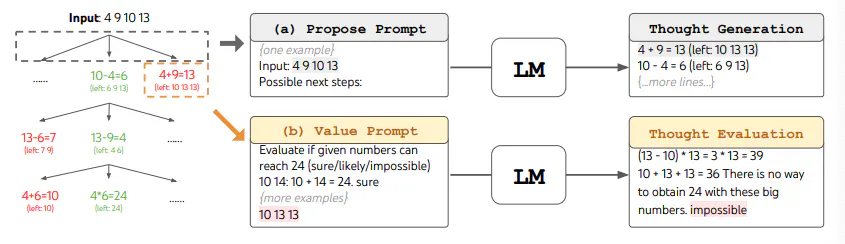

#### Yao et el. (2023)

In [2]:
standard_prompt = '''
Write a coherent passage of 4 short paragraphs. The end sentence of each paragraph must be: {input}
'''

cot_prompt = '''
Write a coherent passage of 4 short paragraphs. The end sentence of each paragraph must be: {input}

Make a plan then write. Your output should be of the following format:

Plan:
Your plan here.

Passage:
Your passage here.
'''


vote_prompt = '''Given an instruction and several choices, decide which choice is most promising. Analyze each choice in detail, then conclude in the last line "The best choice is {s}", where s the integer id of the choice.
'''

compare_prompt = '''Briefly analyze the coherency of the following two passages. Conclude in the last line "The more coherent passage is 1", "The more coherent passage is 2", or "The two passages are similarly coherent".
'''

score_prompt = '''Analyze the following passage, then at the last line conclude "Thus the coherency score is {s}", where s is an integer from 1 to 10.
'''

#### Long (2023)